Davies-Bouldin Index: 1.1640665220704332


<Figure size 1000x800 with 0 Axes>

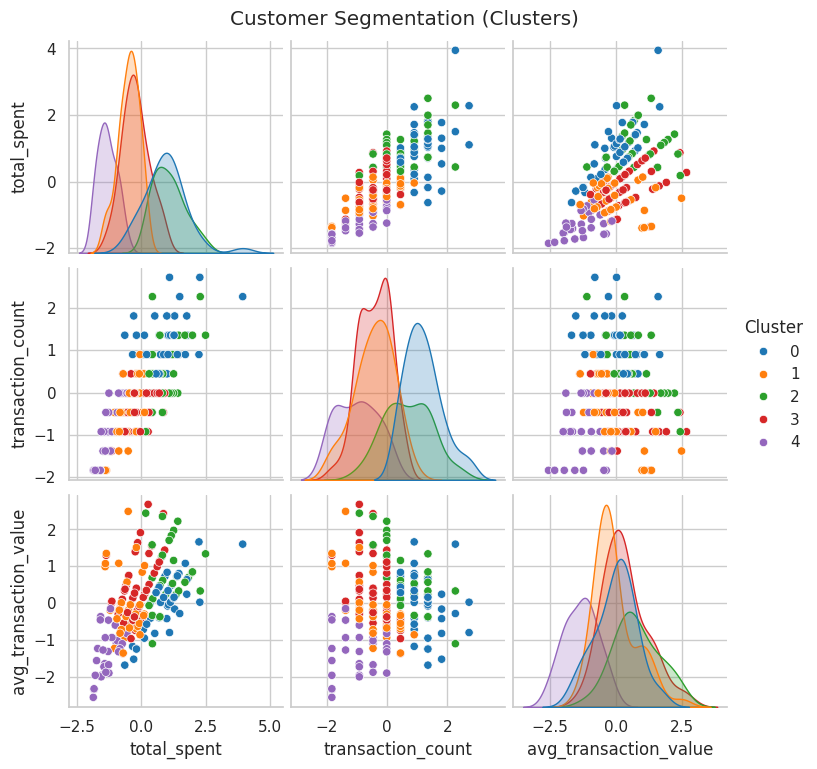

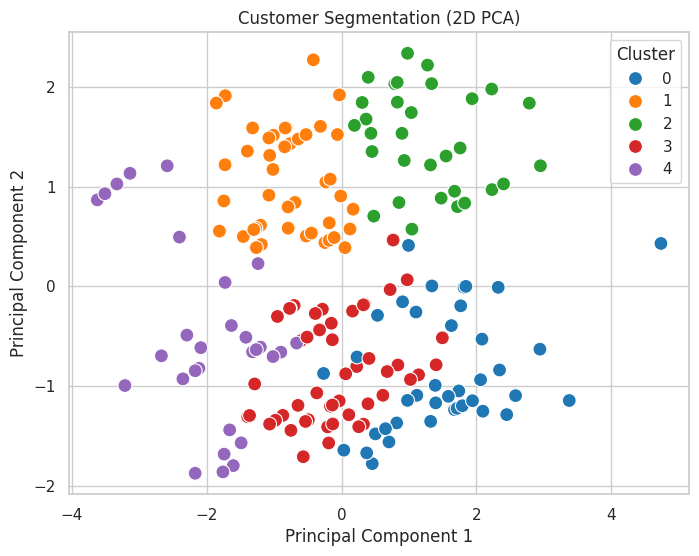

<ipython-input-3-60eef7aea791>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=customer_data, palette='Set2')


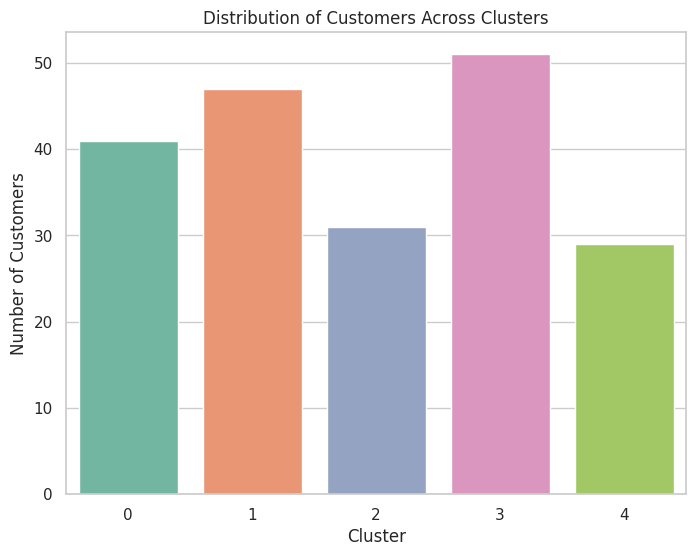

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')
products = pd.read_csv('/content/Products.csv')
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')

# Feature Engineering
customer_data = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    most_frequent_product_category=('Category', lambda x: x.mode()[0])
).reset_index()

# Encoding categorical data
customer_data['Region'] = customer_data['CustomerID'].map(customers.set_index('CustomerID')['Region'])
customer_data['most_frequent_product_category'] = customer_data['most_frequent_product_category'].astype('category').cat.codes

# Normalize the numerical features
scaler = StandardScaler()
customer_data[['total_spent', 'transaction_count', 'avg_transaction_value']] = scaler.fit_transform(
    customer_data[['total_spent', 'transaction_count', 'avg_transaction_value']])

# Extract features to use for clustering
X = customer_data[['total_spent', 'transaction_count', 'avg_transaction_value', 'most_frequent_product_category']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X)

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(X, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize the clusters using a pairplot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.pairplot(customer_data, hue='Cluster', vars=['total_spent', 'transaction_count', 'avg_transaction_value'], palette='tab10')
plt.suptitle('Customer Segmentation (Clusters)', y=1.02)
plt.show()

# Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_data['Cluster'], palette='tab10', s=100)
plt.title('Customer Segmentation (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Show the distribution of customers across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=customer_data, palette='Set2')
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()
